# Auto-encoder for anomaly detection
In this notebook we pursue the idea of training a network to recognize "normal" (non - jumping) signals. This is done by using auto-encoder to reduce the dimensions of a signal to a given amount of dimensions and reconstructing it. Now the loss should be significantly higher for signals not in the training set.

In [179]:
# Imports 
import os 
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

# Taking useful functions from utils.py 
# and loading the data
from utils import get_data, color_list

X_train, X_test, y_train, y_test = get_data()

In [180]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_train_bkg = X_train[y_train == 0, :]

## Define Auto-Encoder / Decoder

In [188]:
# Hyper parameters
input_dims   = 220
latent_dims  = 32
hidden_dims  = 64
dense_layers = 1
dropout      = 0.25

In [189]:
# Tensorflow imports
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Reshape, Flatten, Dropout
from tensorflow.keras.losses import MeanSquaredError


In [190]:
class AutoEncoder(Model):

    def __init__(self, latent_dims, hidden_dims, dense_layers, input_dims = 122):
        super(AutoEncoder, self).__init__()
        self.latens_dims = latent_dims
        
        self.encoder = Sequential([
            # Dense(hidden_dims, activation = "relu"),
            Reshape((input_dims, 1)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Flatten(), 
            Dense(hidden_dims),
            Dense(latent_dims)
        ])
        
        self.decoder = Sequential([
            Dense(input_dims, activation = "relu"),
            Dropout(dropout),
            Reshape((input_dims, 1)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Flatten(), 
            Dense(input_dims)
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded 

autoencoder = AutoEncoder(latent_dims, hidden_dims, dense_layers, input_dims)


In [191]:
autoencoder.compile(optimizer = "adam",
                    loss = MeanSquaredError())

autoencoder.build((None, 220))

In [192]:
autoencoder.summary()

Model: "auto_encoder_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_38 (Sequential)  (None, 32)                1936992   
                                                                 
 sequential_39 (Sequential)  (None, 220)               6236472   
                                                                 
Total params: 8,173,464
Trainable params: 8,173,464
Non-trainable params: 0
_________________________________________________________________


In [193]:
# from keras_lr_finder import LRFinder
# finder = LRFinder(autoencoder)

# finder.find(X_train, X_train, 1e-7, 1e-1, batch_size = 32)

# finder.plot_loss()

# import tensorflow.keras.backend as K


In [194]:
K.set_value(autoencoder.optimizer.learning_rate, 1e-3)
autoencoder.fit(X_train_bkg, X_train_bkg, 
                batch_size = 32,
                epochs     = 10, 
                validation_split = 0.10,
                shuffle = True)

Epoch 1/10
227/227 [==============================] - 114s 461ms/step - loss: 1.5471 - val_loss: 1.1464
Epoch 2/10
227/227 [==============================] - 115s 507ms/step - loss: 1.2015 - val_loss: 0.9547
Epoch 3/10
227/227 [==============================] - 150s 661ms/step - loss: 1.0066 - val_loss: 0.9127
Epoch 4/10
227/227 [==============================] - 153s 672ms/step - loss: 0.8873 - val_loss: 0.8385
Epoch 5/10
227/227 [==============================] - 150s 660ms/step - loss: 0.8169 - val_loss: 0.7858
Epoch 6/10
227/227 [==============================] - 128s 566ms/step - loss: 0.7687 - val_loss: 0.7148
Epoch 7/10
227/227 [==============================] - 137s 602ms/step - loss: 0.7260 - val_loss: 0.8056
Epoch 8/10
227/227 [==============================] - 104s 458ms/step - loss: 0.6912 - val_loss: 0.7299
Epoch 9/10
227/227 [==============================] - 138s 608ms/step - loss: 0.6743 - val_loss: 0.7258
Epoch 10/10
227/227 [==============================] - ETA: 0s -

In [175]:
enc = autoencoder.encoder(scaler.transform(X_test))
dec = autoencoder.decoder(enc)
dec = scaler.inverse_transform(dec)
enc = enc.numpy()



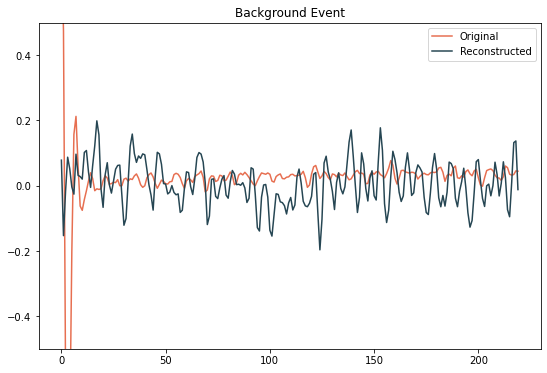

In [176]:
plot_example = 46
fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(X_test[plot_example, :], c = color_list[4], label = "Original") 
ax.plot(dec[plot_example, :],    c = color_list[0], label = "Reconstructed")

if y_test[plot_example] == 1:
    ax.set_title("Signal Event")
else:
    ax.set_title("Background Event")

ax.set_ylim(-0.5, 0.5)

ax.legend()

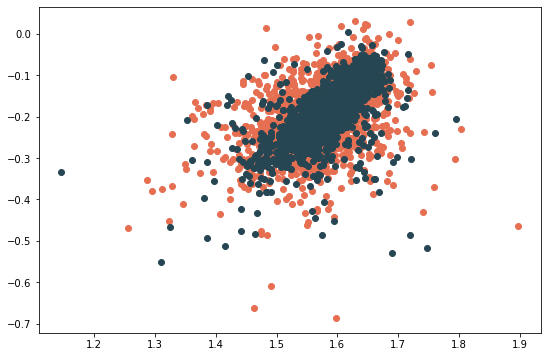

In [177]:
fig, ax = plt.subplots(figsize = (9, 6))

mask = y_test == 1

ax.scatter(enc[mask, 0],  enc[mask, 1],  c = color_list[4], marker = "o", label = "Signal") 
ax.scatter(enc[~mask, 0], enc[~mask, 1], c = color_list[0], marker = "o", label = "background")

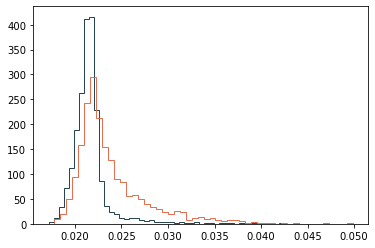

In [178]:
x_test_bkg = scaler.transform(X_test[y_test == 0])
x_test_sig = scaler.transform(X_test[y_test == 1])

mse = tf.keras.losses.MeanSquaredError(reduction = "none")

bkg_losses = mse(x_test_bkg, autoencoder(x_test_bkg)).numpy()
sig_losses = mse(x_test_sig, autoencoder(x_test_sig)).numpy()

plt.hist(bkg_losses, bins = 50, histtype = "step", color = color_list[0], label = "background")
plt.hist(sig_losses, bins = 50, histtype = "step", color = color_list[4], label = "signal");



In [160]:
from sk

array([0.0239404 , 0.03851635, 0.02644325, ..., 0.02322501, 0.0245908 ,
       0.02300784], dtype=float32)